In [13]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from tensorflow.keras.applications.resnet import preprocess_input # ResNet'in özel

# 1) DATA PREPROCESSING


In [2]:
# --- 1. CONFIGURATION ---
# Define the path to your dataset folder on Kaggle/Colab
KAGGLE_DATA_PATH = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
CLASS_NAMES = ['Cyst', 'Normal', 'Stone', 'Tumor']
NUM_CLASSES = len(CLASS_NAMES)

In [5]:
IMG_SIZE = (224, 224) # Standard input size for ResNet50
BATCH_SIZE = 32
RANDOM_SEED = 42 


## 1.1. Data Loading and Strategic Splitting
Data Loading and DataFrame: All image file paths and their respective labels were loaded into a central Pandas DataFrame.

Strategic Split (80%/10%/10%): The dataset was carefully partitioned into three distinct sets to ensure robust testing:

* Training (≈80%): The largest portion, used for the model's actual learning process.

* Validation (≈10%): Used to monitor the model's performance after every epoch and guide the Early Stopping mechanism, helping to prevent overfitting.

* Test (≈10%): Completely held out until the very end. This set provides the final, unbiased measure of how well the model generalizes to entirely unseen data.

In [6]:
# --- 2. DATA FRAME CREATION AND STRATIFIED SPLIT (70/15/15) ---

print("Starting data frame creation and stratified splitting...")

all_data = []
for class_name in CLASS_NAMES:
    class_dir = os.path.join(KAGGLE_DATA_PATH, class_name)
    for image_name in os.listdir(class_dir):
        if image_name.endswith(('.png', '.jpg', '.jpeg')):
            all_data.append({
                'filepath': os.path.join(class_dir, image_name),
                'label': class_name
            })

df = pd.DataFrame(all_data)

# Step 1: Split into 70% Train and 30% Temp (Temp will be split into Val/Test)
# Use 'stratify' to ensure class distribution is maintained
train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=RANDOM_SEED, stratify=df['label']
)

# Step 2: Split Temp (30%) into 15% Validation and 15% Test
# Since 15/30 = 0.5, we use test_size=0.5
validation_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=RANDOM_SEED, stratify=temp_df['label']
)

print(f"Total Images: {len(df)}")
print(f"Train Set: {len(train_df)} ({len(train_df)/len(df):.1%})")
print(f"Validation Set: {len(validation_df)} ({len(validation_df)/len(df):.1%})")
print(f"Test Set: {len(test_df)} ({len(test_df)/len(df):.1%})")

Starting data frame creation and stratified splitting...
Total Images: 12446
Train Set: 8712 (70.0%)
Validation Set: 1867 (15.0%)
Test Set: 1867 (15.0%)


## 1.2. Core Configuration and Data Augmentation
Image Scaling and Batch Size: The image size was standardized to the ResNet50 requirement of 224×224 pixels, and a standard 32 batch size was set for efficient GPU utilization.

Training Data Augmentation (train_datagen): Extensive transformations were applied to the training set:

* Goal: To drastically increase the diversity of the training data and build a robust model that does not simply memorize patterns.

* Techniques: Random rotations, shifts, zooms, and horizontal flips were used. This forces the model to learn the intrinsic features of a 'Tumor' or 'Stone' regardless of its position or orientation in the scan.

## 1.3. Validation and Test Set Scaling Only
For the validation and test sets (valid_test_datagen), only basic scaling was performed:

* Rescaling: Pixel values were scaled by 1/255 to normalize the data between 0.0 and 1.0.

* No Augmentation: It is crucial that validation and test images remain unaltered by random transformations. This preserves the integrity of these sets, ensuring that the accuracy metrics truly reflect the model's performance on realistic, new data.

## 1.4. Efficient Data Loaders (flow_from_directory)
The ImageDataGenerator's powerful flow_from_directory() (or flow_from_dataframe()) method was used to create the three data loaders:

* Automatic Labeling: The loaders automatically inferred the 4 class labels from the folder structure and converted them into the required categorical format.

* Consistent Test Order: The test_generator was specifically set with shuffle=False. This is essential for accurate post-training analysis, as it guarantees that the predictions, labels, and confusion matrix reports align perfectly with the original test image sequence.

* Class Name Extraction: Finally, train_generator.class_indices.keys() provided the definitive list of class names, essential for interpreting the model's predicted output (e.g., matching prediction index 2 to 'Stone').

In [7]:

# --- 3. DATA GENERATORS (flow_from_dataframe) ---

# ResNet50 uses a specific preprocessing function. We will use it with ImageDataGenerator.
from tensorflow.keras.applications.resnet import preprocess_input

# 1. Training Generator (with Augmentation and ResNet Preprocessing)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Use ResNet's specific preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# 2. Validation and Test Generators (only Preprocessing)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col='filepath', y_col='label', target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=validation_df, x_col='filepath', y_col='label', target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df, x_col='filepath', y_col='label', target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False # Don't shuffle test data
)


Found 8712 validated image filenames belonging to 4 classes.
Found 1867 validated image filenames belonging to 4 classes.
Found 1867 validated image filenames belonging to 4 classes.


# 2) DATA VISUALIZATION


## 2.1. Class Count Extraction and Data Preparation
1. Extracting Counts: The script begins by using value_counts() on the 'label' column of each pre-existing DataFrame (train_df, validation_df, test_df). This returns the exact number of images for each class within each split, storing them as dictionaries (train_counts, etc.).

2. Structuring for Plotting: The dictionaries are converted into small DataFrames (df_train, df_valid, df_test).

3. Merging DataFrames: The individual DataFrames are merged using the 'Class' name as the key. This creates a single DataFrame (df_combined) that holds the side-by-side counts for all three datasets for every class.

4. Total Verification (Optional): A 'Total' column is calculated to quickly confirm the total count of each class across the entire original dataset.

## 2.2. Plot Generation (Bar Chart)
A Bar Chart is generated to provide a clear visual comparison of the class distribution:

* Visualization: The resulting graph clearly shows the counts for 'Train Count', 'Valid Count', and 'Test Count' grouped by class (Cyst, Normal, Stone, Tumor).

* Verification: If the stratified split was successful, the bars for each class should appear roughly proportional (e.g., the 'Train Count' bar should be approximately 80% of the total height for that class).

* Imbalance Confirmation: The chart immediately highlights the class imbalance problem in the original dataset (e.g., the 'Normal' class having significantly more images than the 'Stone' class across all three splits). This confirms the necessity of using Class Weighting later in the training process.

## 2.3. Numerical Output (Verification)
The script concludes by printing the raw numerical counts for final verification:

* Purpose: The printed dictionaries provide precise numerical proof that the stratified splitting mechanism successfully partitioned the data while maintaining the intended class ratios (e.g., 80:10:10). This confirms the integrity of the data pipeline before model training begins.

<Figure size 1200x600 with 0 Axes>

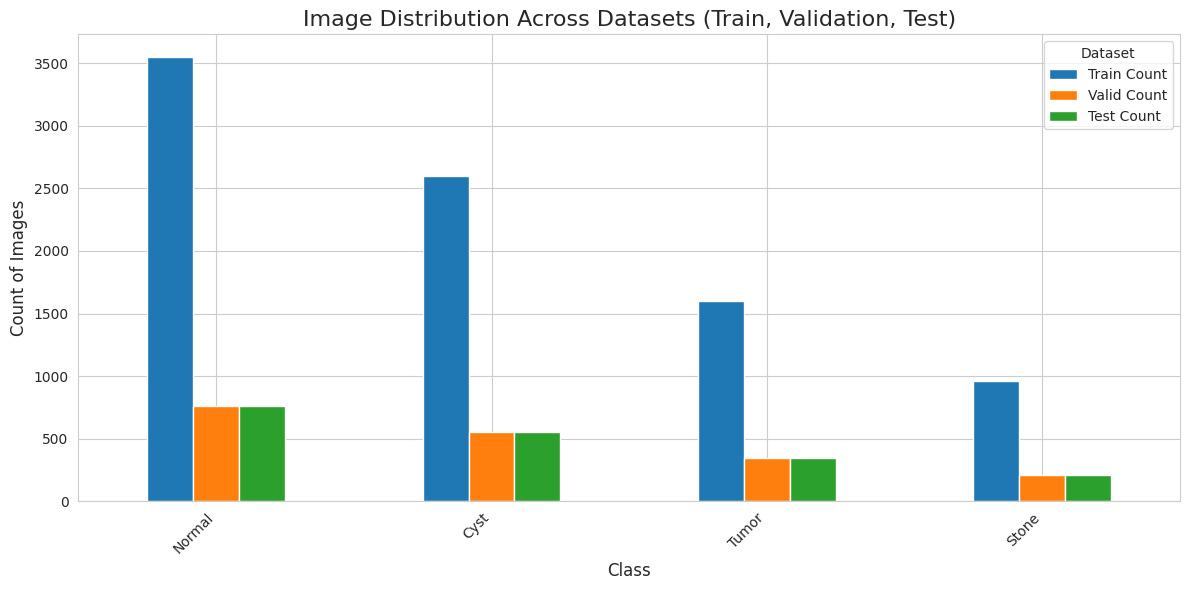


--- NUMERICAL DISTRIBUTION (STRATIFIED SPLIT VERIFICATION) ---
Training Set Distribution: {'Normal': 3554, 'Cyst': 2596, 'Tumor': 1598, 'Stone': 964}
Validation Set Distribution: {'Normal': 762, 'Cyst': 556, 'Tumor': 343, 'Stone': 206}
Test Set Distribution: {'Normal': 761, 'Cyst': 557, 'Tumor': 342, 'Stone': 207}
--------------------------------------------------
Combined Counts per Class:
         Train Count  Valid Count  Test Count  Total
Class                                              
Normal         3554          762         761   5077
Cyst           2596          556         557   3709
Tumor          1598          343         342   2283
Stone           964          206         207   1377


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: This code block assumes that 'train_df', 'validation_df', and 'test_df'
# DataFrames have already been created and are available in the memory 
# from the previous steps (the 70/15/15 stratified split).

# --- 1. EXTRACT CLASS COUNTS FROM DATAFRAMES ---
# Count the occurrences of each class label in the 'label' column
train_counts = train_df['label'].value_counts().to_dict()
valid_counts = validation_df['label'].value_counts().to_dict()
test_counts = test_df['label'].value_counts().to_dict()

# --- 2. VISUALIZATION SETUP ---

# Convert counts dictionaries into DataFrames
df_train = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Train Count'])
df_valid = pd.DataFrame(list(valid_counts.items()), columns=['Class', 'Valid Count'])
df_test = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Test Count'])

# Merge the dataframes based on 'Class' name
df_combined = pd.merge(df_train, df_valid, on='Class')
df_combined = pd.merge(df_combined, df_test, on='Class')
df_combined = df_combined.set_index('Class')

# Optional: Add a 'Total' column for quick verification
df_combined['Total'] = df_combined['Train Count'] + df_combined['Valid Count'] + df_combined['Test Count']

# --- 3. PLOT GENERATION ---

plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Generate the bar plot showing counts for each set
df_combined[['Train Count', 'Valid Count', 'Test Count']].plot(kind='bar', figsize=(12, 6))
plt.title('Image Distribution Across Datasets (Train, Validation, Test)', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# --- 4. NUMERICAL OUTPUT ---
print("\n--- NUMERICAL DISTRIBUTION (STRATIFIED SPLIT VERIFICATION) ---")
print("Training Set Distribution:", train_counts)
print("Validation Set Distribution:", valid_counts)
print("Test Set Distribution:", test_counts)
print("-" * 50)
print("Combined Counts per Class:\n", df_combined)

## 2.4. Visualize Images

This code block serves as the initial visual audit of the dataset. Before writing any data loading or modeling code, it's essential to visualize raw samples to understand the image quality, content, and the nature of the classification task.

Checking data path: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone


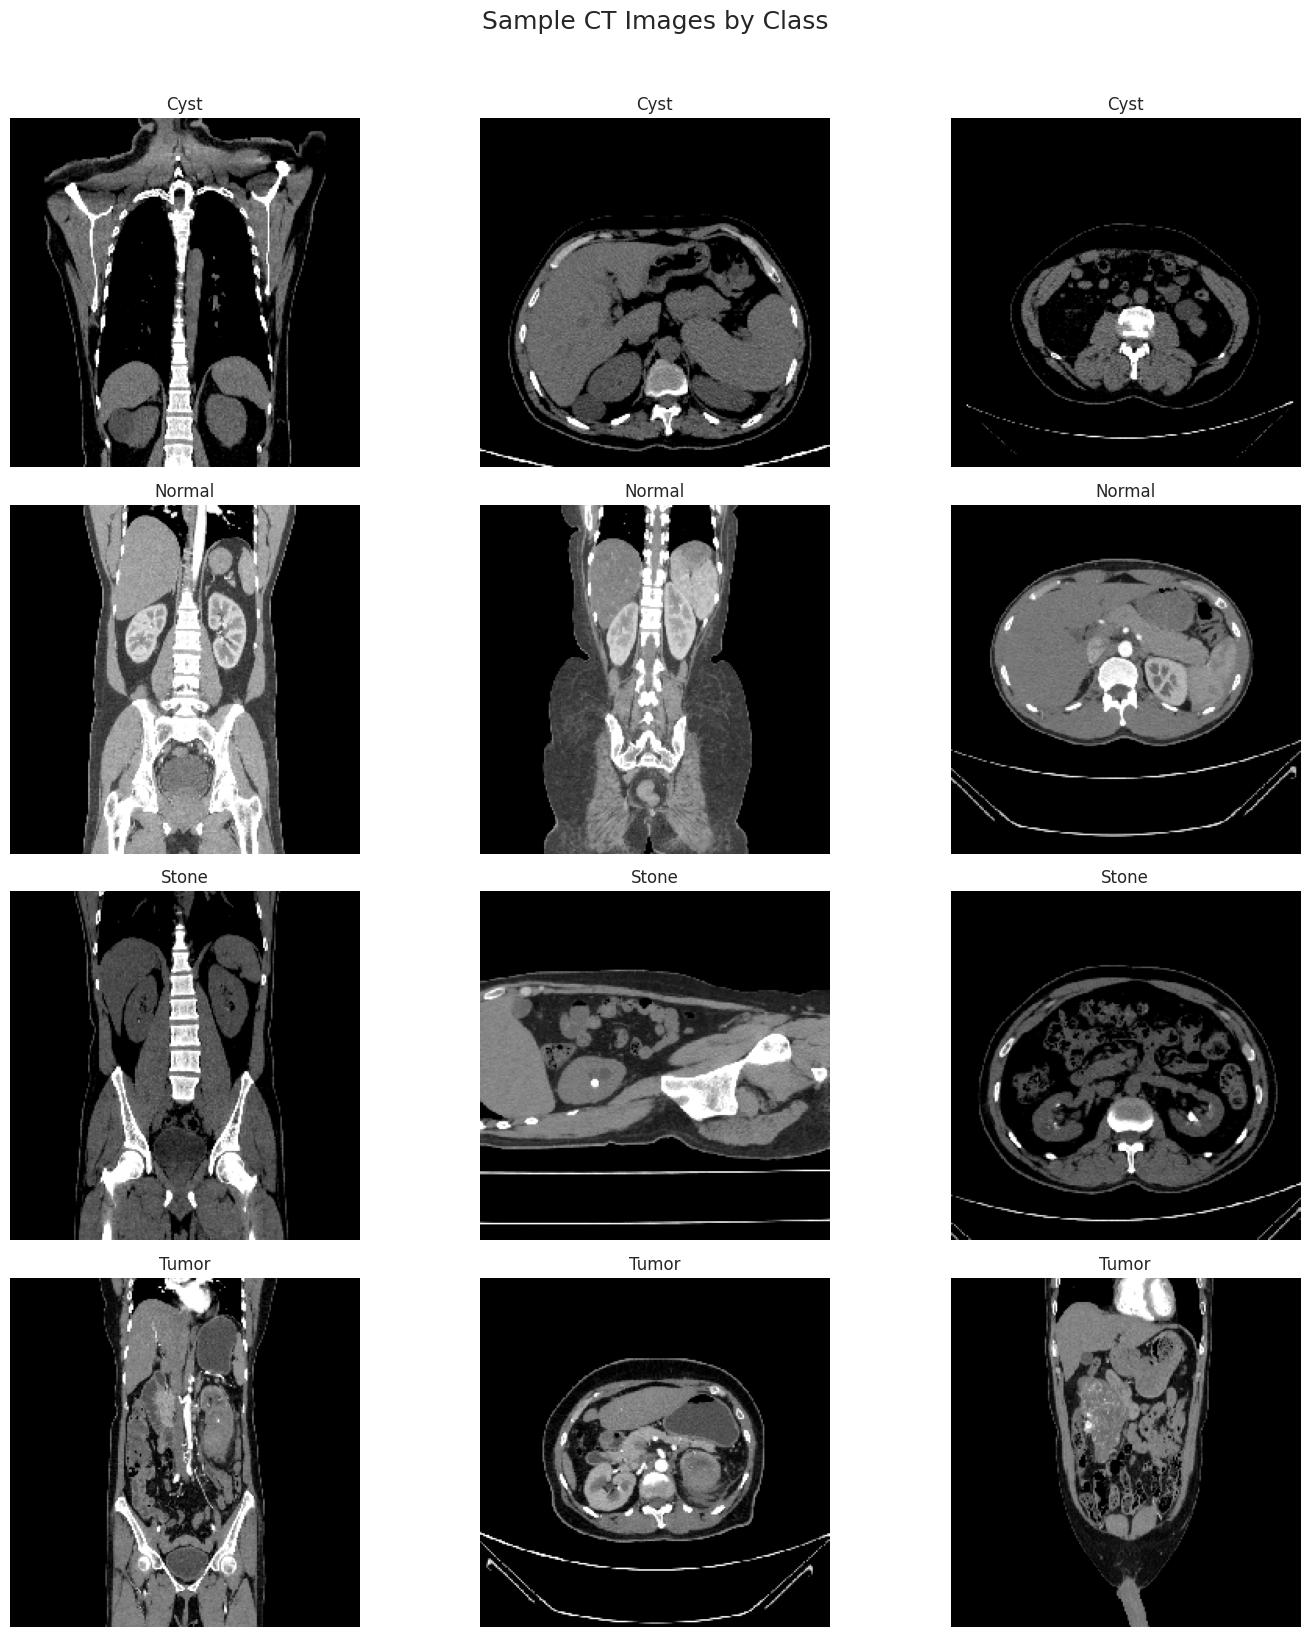

In [11]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- CONFIGURATION ---
# Path to your main dataset folder (where the original class folders reside)
KAGGLE_DATA_PATH = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
# Number of random examples to show per class
NUM_EXAMPLES = 3 
# Target size for visualization (matches ResNet input size)
TARGET_SIZE = (224, 224) 

# Class names (subfolders in your main data path)
CLASS_NAMES = ['Cyst', 'Normal', 'Stone', 'Tumor'] 
# --------------------

print(f"Checking data path: {KAGGLE_DATA_PATH}")

if os.path.exists(KAGGLE_DATA_PATH):
    
    # Set up the Matplotlib figure size
    plt.figure(figsize=(15, len(CLASS_NAMES) * 4))

    for i, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(KAGGLE_DATA_PATH, class_name)
        
        if not os.path.isdir(class_path):
            print(f"Warning: Class folder '{class_name}' not found or is not a directory.")
            continue
            
        # Get all image files in the class folder
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            print(f"Warning: No images found in '{class_name}' folder.")
            continue
            
        # Pick random samples
        sample_images = random.sample(image_files, min(len(image_files), NUM_EXAMPLES))

        # Display the images
        for j, image_file in enumerate(sample_images):
            # Calculate the subplot position
            ax = plt.subplot(len(CLASS_NAMES), NUM_EXAMPLES, i * NUM_EXAMPLES + j + 1)
            
            img_path = os.path.join(class_path, image_file)
            
            # Load and resize the image
            img = load_img(img_path, target_size=TARGET_SIZE)
            img_array = img_to_array(img)
            
            # Use 'uint8' for correct color rendering in matplotlib
            plt.imshow(img_array.astype('uint8')) 
            plt.title(class_name, fontsize=12)
            plt.axis('off')

    plt.suptitle('Sample CT Images by Class', fontsize=18, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 1.0]) # Adjust layout to fit suptitle
    plt.show()

else:
    print(f"Error: Main data folder '{KAGGLE_DATA_PATH}' not found. Please verify the path.")

# 3) CLASS WEIGHTS

## 3.1. The Class Imbalance Problem
The numerical distribution shows a significant imbalance:

Normal:	3554, 40.6% (Highest)
 
Cyst:	2596, 29.7%

Tumor:	1598, 18.3%

Stone:	964, 11.0% (Lowest)

If trained without weights, the model would achieve a deceptively high accuracy by simply predicting the majority classes ('Normal', 'Cyst') most of the time, leading to high false negatives for the crucial minority classes ('Stone', 'Tumor').

**By applying these weights, the model is forced to pay more attention to correctly classifying the rare but critical cases ('Stone' and 'Tumor'), which is essential for achieving the high Recall (sensitivity) seen in your final evaluation.**

In [9]:
# Training set numerical distribution:
train_counts = {'Normal': 3554, 'Cyst': 2596, 'Tumor': 1598, 'Stone': 964}

# Using Class Indices
# Keras Generators use indices (0, 1, 2, 3), not class names.
# We retrieve these indices from your train_generator.
# Example: {'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}
class_indices = train_generator.class_indices 

# Total number of training samples
total_samples = sum(train_counts.values()) 
num_classes = len(train_counts)

# Calculate weights to create the class_weight dictionary
class_weights = {}
for class_name, count in train_counts.items():
    # Weight = Total Samples / (Number of Classes * Count of that Class)
    weight = total_samples / (num_classes * count)
    
    # Add the weight to the dictionary using the index format Keras expects
    class_index = class_indices[class_name]
    class_weights[class_index] = weight

print("Calculated Raw Class Weights (class_weight):")
print(class_weights)

# We could normalize the weights so that the largest weight equals 1 for easier readability.
# However, Keras accepts the raw weight values, and we will use the raw values here.

# The resulting class_weights dictionary must contain indices 0, 1, 2, 3.
# Example: {1: 0.89, 0: 1.22, 3: 1.99, 2: 3.28}

Hesaplanan Ham Sınıf Ağırlıkları (class_weight):
{1: 0.6128306133933596, 0: 0.8389830508474576, 3: 1.362953692115144, 2: 2.259336099585062}


# 4) MODEL TRAINING

## 4.1. Set Parameters

In [24]:

# Stage 1 Training Parameters
STAGE1_LR = 1e-4 # Higher learning rate for training new layers
STAGE1_EPOCHS = 10

# Stage 2 (Fine-Tuning) Parameters
STAGE2_LR = 1e-5 # Very low learning rate for fine-tuning
STAGE2_EPOCHS = 75 # More epochs for subtle weight adjustments


## 4.2. Train Model In 2 Stage

**Stage 1: Training the Top Layers**
The goal of this initial stage is to quickly teach the model how to classify your specific images without changing the core knowledge of the pre-trained ResNet50 model.

* Load ResNet50
* Add new layers:
    GlobalAveragePooling2D(),
    
    Dense(512, activation='relu'),
    
    Dropout(0.3), # Dropout value set to 0.3
    
    Dense(NUM_CLASSES, activation='softmax')

* Compile model with adam optimizer

**Stage 2: Fine-Tuning the Model**

After the top layers have learned to classify the images, this stage refines the entire model by making small, precise adjustments to some of the pre-trained weights.

* Unfreezing Layers: I set base_model.trainable = True, which unfreezes the entire ResNet50 model. However, I then used a loop to freeze all but the last 50 layers of the base model. 

* Re-compiling: I re-compiled the model with a much smaller learning rate.

* Adding Callbacks:

  
  EarlyStopping: This monitors the validation loss and automatically stops training if the model's performance on the validation set stops improving. It prevents overfitting and saves time.

  ModelCheckpoint: This saves a copy of the model every time the validation accuracy (val_accuracy) reaches a new high. save_best_only=True ensures that only the best-performing version of the model is kept.

* Final Training:

  
* Final Evaluation After both training stages were complete, I loaded the best model saved by ModelCheckpoint. This is the most accurate version of the model on the validation set. I then evaluated this final model on the test set, which it has never seen before, to get an unbiased measure of its true performance. The final printed Test Accuracy and Test Loss values show how well the model is expected to perform in a real-world scenario.

    


--- STAGE 1: FEATURE EXTRACTION STARTING ---
Stage 1 Model Compiled. Training Starting...
Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.5412 - loss: 1.1086
Epoch 1: val_accuracy improved from -inf to 0.80289, saving model to best_stage1_model.h5
273/273 ━━━━━━━━━━━━━━━━━━━━ 151s 503ms/step - accuracy: 0.5416 - loss: 1.1077 - val_accuracy: 0.8029 - val_loss: 0.5461
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7908 - loss: 0.5701
Epoch 2: val_accuracy improved from 0.80289 to 0.82807, saving model to best_stage1_model.h5
273/273 ━━━━━━━━━━━━━━━━━━━━ 123s 449ms/step - accuracy: 0.7909 - loss: 0.5699 - val_accuracy: 0.8281 - val_loss: 0.4716
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8459 - loss: 0.4158
Epoch 3: val_accuracy improved from 0.82807 to 0.87520, saving model to best_stage1_model.h5
273/273 ━━━━━━━━━━━━━━━━━━━━ 121s 445ms/step - accuracy: 0.8459 - loss: 0.4157 - val_accuracy: 0.8752 - val_loss: 0.3352
Epoch 

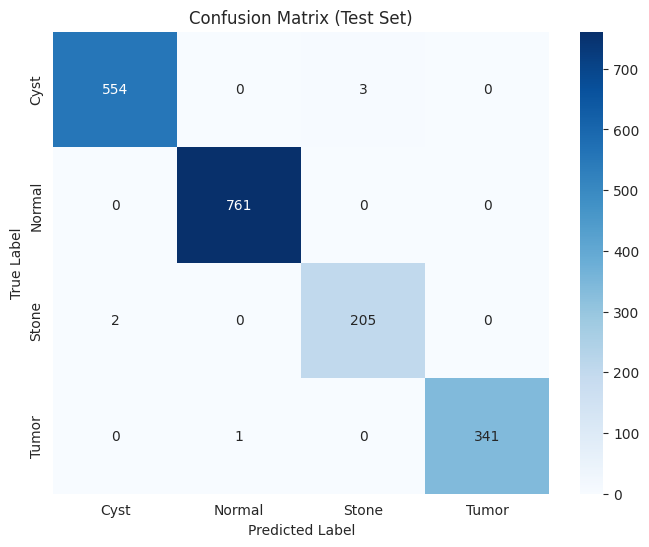


Model training and comprehensive analysis successfully completed.


In [25]:

# --- 3. STAGE 1: FEATURE EXTRACTION (Train only new layers) ---

print("\n--- STAGE 1: FEATURE EXTRACTION STARTING ---")

# Load the ResNet50 Base Model (with ImageNet weights and no top classifier)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the convolutional layers
base_model.trainable = False

# Add New Classification Layers (Head)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), 
    Dense(512, activation='relu'),
    Dropout(0.3), # Dropout value set to 0.3
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=STAGE1_LR),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Callback: Save the best Stage 1 weights based on validation accuracy
stage1_checkpoint = ModelCheckpoint('best_stage1_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

print("Stage 1 Model Compiled. Training Starting...")

# Start Training (USING CLASS WEIGHTS)
history_stage1 = model.fit(
    train_generator,
    epochs=STAGE1_EPOCHS,
    validation_data=validation_generator,
    callbacks=[stage1_checkpoint],
    class_weight=class_weights  # <<< CLASS WEIGHTING APPLIED HERE!
)

# --- 4. STAGE 2: FINE-TUNING (Low Learning Rate) ---

print("\n--- STAGE 2: FINE-TUNING STARTING (Unfreezing Last 50 Layers) ---")

# Load the best weights from Stage 1
model.load_weights('best_stage1_model.h5')

# 1. Unfreeze the entire ResNet50 base model initially
base_model.trainable = True

# 2. Freeze the initial layers of ResNet50 (Keep only the last 50 unfrozen)
FINE_TUNE_AT = len(base_model.layers) - 50 # Only the last 50 layers will remain unfrozen

for i, layer in enumerate(base_model.layers):
    if i < FINE_TUNE_AT:
        layer.trainable = False
    # Layers at index >= FINE_TUNE_AT are left trainable (unfrozen)

# IMPORTANT: Keep Batch Normalization (BN) layers frozen (Best practice for fine-tuning)
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Recompile the model with a VERY LOW learning rate
model.compile(optimizer=Adam(learning_rate=STAGE2_LR),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks: Early Stopping and Final Best Model Checkpoint
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3,             
    min_delta=0.0001,        
    restore_best_weights=True)
    
ft_checkpoint = ModelCheckpoint(
    'final_best_model.h5',     
    monitor='val_accuracy', 
    save_best_only=True,
    mode='max',
    verbose=1)

print("Stage 2 Model Recompiled. Fine-Tuning Starting...")

# Start Training (USING CLASS WEIGHTS)
history_fine_tune = model.fit(
    train_generator,
    epochs=STAGE2_EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, ft_checkpoint],
    class_weight=class_weights  
)

print("\nTwo-Stage Training Completed. The best model is saved as 'final_best_model.h5'.")

# --- 5. FINAL TEST SET COMPREHENSIVE EVALUATION ---

print("\n--- FINAL MODEL COMPREHENSIVE EVALUATION ON TEST SET ---")

final_model = tf.keras.models.load_model('final_best_model.h5')
loss, accuracy = final_model.evaluate(test_generator)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Retrieve predictions and compute metrics
test_generator.reset() 
predictions = final_model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

idx_to_class = dict((v, k) for k, v in test_generator.class_indices.items())
class_labels = [idx_to_class[i] for i in range(len(test_generator.class_indices))]

# Classification Report (Crucial for Imbalanced Data)
print("\n--- CLASSIFICATION REPORT (Recall, Precision, F1-Score) ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nModel training and comprehensive analysis successfully completed.")

# 5) TEST 

## 5.1. Validation and Loss Graph

The following function will merge the history objects from Stage 1 (history_stage1) and Stage 2 (history_fine_tune) and plot the Accuracy and Loss for both the training and validation sets in a single, continuous graph. This clearly shows the performance jump from feature extraction to fine-tuning.

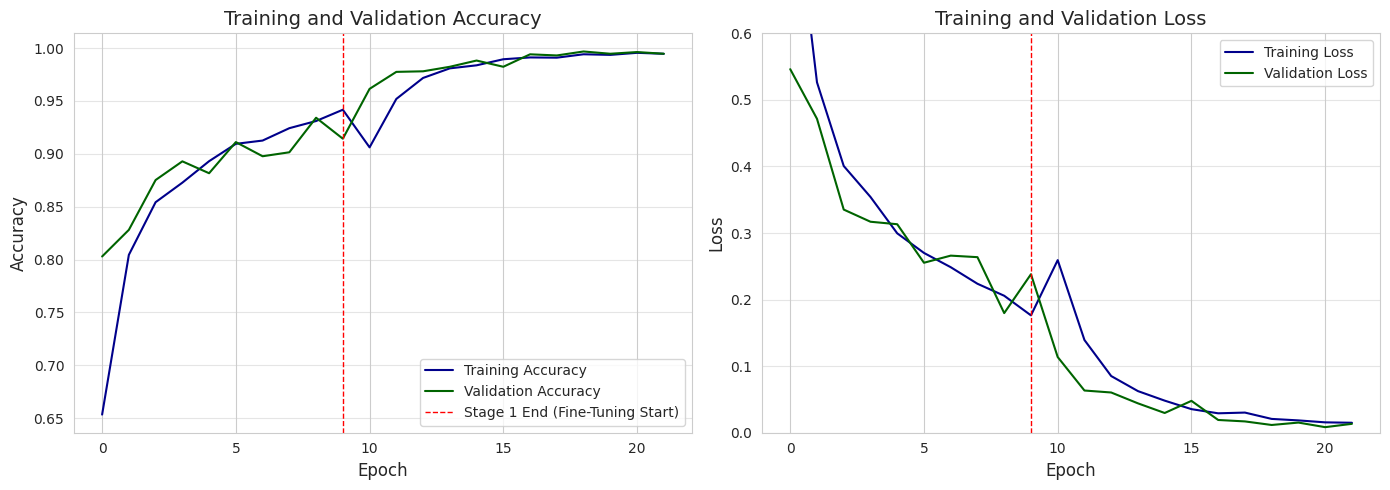

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history_stage1, history_stage2, initial_epochs):
    """
    Plots the accuracy and loss curves for a two-stage training process 
    (Feature Extraction and Fine-Tuning).
    
    Args:
        history_stage1: The Keras History object from Stage 1.
        history_stage2: The Keras History object from Stage 2.
        initial_epochs: The number of epochs run in Stage 1, used to separate the plots.
    """
    
    # 1. Concatenate Histories
    # Note: history_stage2 may have fewer than the set 75 epochs due to Early Stopping.
    acc = history_stage1.history['accuracy'] + history_stage2.history['accuracy']
    val_acc = history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy']

    loss = history_stage1.history['loss'] + history_stage2.history['loss']
    val_loss = history_stage1.history['val_loss'] + history_stage2.history['val_loss']
    
    # Calculate the actual total number of epochs
    total_epochs = len(acc)
    epochs_range = range(total_epochs)

    # 2. Create the Plot
    plt.figure(figsize=(14, 5))

    # --- Accuracy Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='darkblue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='darkgreen')
    
    # Draw a vertical line to separate the stages
    plt.axvline(x=initial_epochs - 1, color='red', linestyle='--', linewidth=1, 
                label='Stage 1 End (Fine-Tuning Start)')
    
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(axis='y', alpha=0.5)
    
    # --- Loss Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='darkblue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='darkgreen')
    
    # Draw a vertical line to separate the stages
    plt.axvline(x=initial_epochs - 1, color='red', linestyle='--', linewidth=1)
    
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right')
    # Since the loss dropped very fast, we might set a tighter y-limit to see the Stage 2 details
    if np.max(val_loss) > 0.6:
        plt.ylim(0, np.max(val_loss) * 1.1)
    else:
        # A manual limit for better visibility of the very low loss values
        plt.ylim(0, 0.6) 

    plt.grid(axis='y', alpha=0.5)

    plt.tight_layout()
    plt.show()

# --- EXAMPLE USAGE ---
# This assumes your history objects and STAGE1_EPOCHS variable are still available:
# STAGE1_EPOCHS = 10 
plot_training_history(history_stage1, history_fine_tune, STAGE1_EPOCHS)

## 5.2. Visualizing Random Test Set Predictions

The following code block uses the final_best_model.h5 successfully trained and loads 8 random images from your Test Set to make predictions and visualize the results.

Model 'final_best_model.h5' successfully loaded.


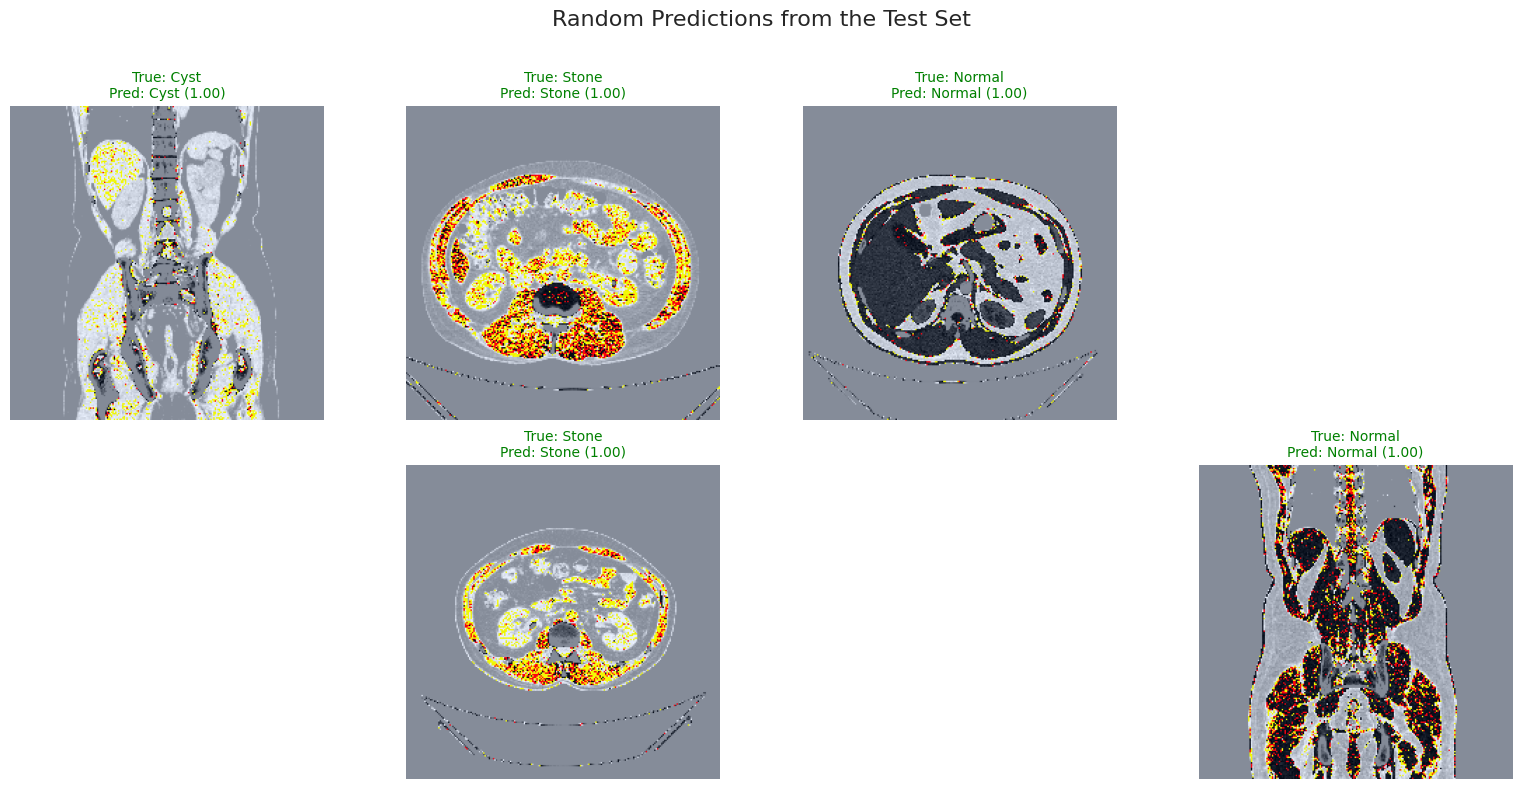

In [20]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import preprocess_input

# --- 1. CONFIGURATION ---
NUM_SAMPLES = 8  # Number of examples to display
IMG_SIZE = (224, 224)
MODEL_PATH = 'final_best_model.h5'

# Get the class labels from the Test Generator (assuming test_generator is still defined)
# IMPORTANT: This uses the class_indices property from the previously created test_generator.
class_labels = list(test_generator.class_indices.keys())
# ------------------------

# Load the final best model
try:
    final_model = tf.keras.models.load_model(MODEL_PATH)
    print(f"Model '{MODEL_PATH}' successfully loaded.")
except Exception as e:
    print(f"Error: Could not load the model. Check the path. Error: {e}")
    # You might want to exit here if running in a script
    # exit() 

# Select random samples from the Test DataFrame
# Uses a random_state for reproducible (but still random) selection each time
sample_df = test_df.sample(n=NUM_SAMPLES, random_state=random.randint(1, 1000))

plt.figure(figsize=(16, 8))
plt.suptitle("Random Predictions from the Test Set", fontsize=16)

for i, row in sample_df.iterrows():
    img_path = row['filepath']
    true_label = row['label']

    # 1. Load and Preprocess the Image
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    
    # Expand dimensions to create a batch size of 1: (1, 224, 224, 3)
    img_batch = np.expand_dims(img_array, axis=0) 
    
    # Apply ResNet's specific preprocessing function
    processed_img = preprocess_input(img_batch)
    
    # 2. Make Prediction
    prediction = final_model.predict(processed_img, verbose=0)[0]
    
    # Find the class with the highest probability
    predicted_index = np.argmax(prediction)
    predicted_label = class_labels[predicted_index]
    confidence = prediction[predicted_index]

    # 3. Visualize
    plt.subplot(2, 4, i % NUM_SAMPLES + 1)
    
    # Display the original image (need to cast back to uint8 for matplotlib)
    plt.imshow(img_array.astype('uint8'))
    
    # Set title color (Green for correct, Red for incorrect)
    color = "green" if predicted_label == true_label else "red"
    
    title = f"True: {true_label}\nPred: {predicted_label} ({confidence:.2f})"
    plt.title(title, color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout for suptitle
plt.show()

## 5.3. Single External Image Prediction Script



Model 'final_best_model.h5' successfully loaded.


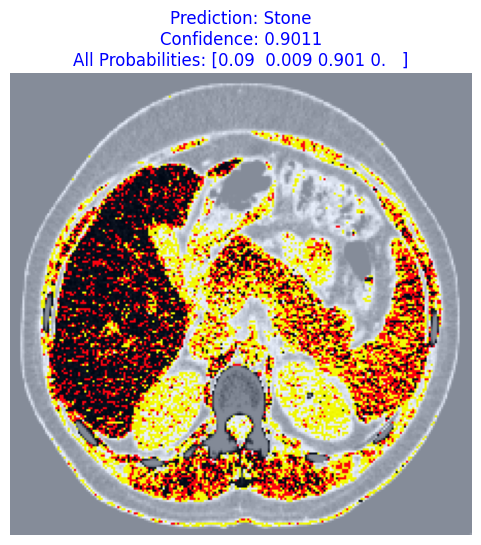

('Stone', 0.9010763)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import preprocess_input

# --- CONFIGURATION ---
IMG_SIZE = (224, 224)
MODEL_PATH = 'final_best_model.h5'
# Model's class labels
# IMPORTANT: This list must be in the same order as your test_generator classes.
CLASS_LABELS = ['Cyst', 'Normal', 'Stone', 'Tumor'] 
# --------------------

# Load the final saved model (if not already loaded)
try:
    # Assuming final_model is not globally available in this new block, we load it again
    final_model = tf.keras.models.load_model(MODEL_PATH) 
    print(f"Model '{MODEL_PATH}' successfully loaded.")
except Exception as e:
    print(f"Error: Could not load the model. Please check the path. Error: {e}")
    # You may need to handle the execution halt here

def make_single_prediction(image_path: str):
    """
    Loads, preprocesses, and makes a prediction on a single image file.
    """
    try:
        # 1. Load and Resize the Image
        img = load_img(image_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        
        # 2. Preprocessing
        # Expand dimensions to create a batch size of 1: (1, 224, 224, 3)
        img_batch = np.expand_dims(img_array, axis=0) 
        # Apply ResNet preprocessing function
        processed_img = preprocess_input(img_batch)
        
        # 3. Make Prediction
        prediction = final_model.predict(processed_img, verbose=0)[0]
        
        # Find the class with the highest probability
        predicted_index = np.argmax(prediction)
        predicted_label = CLASS_LABELS[predicted_index]
        confidence = prediction[predicted_index]

        # 4. Visualize
        plt.figure(figsize=(6, 6))
        # Display the original image (need to cast back to uint8)
        plt.imshow(img_array.astype('uint8'))
        
        title = (f"Prediction: {predicted_label}\n"
                 f"Confidence: {confidence:.4f}\n"
                 f"All Probabilities: {np.round(prediction, 3)}")
        
        plt.title(title, fontsize=12, color='blue')
        plt.axis('off')
        plt.show()
        
        return predicted_label, confidence
        
    except FileNotFoundError:
        print(f"Error: The specified file path was not found: {image_path}")
        return None, None
    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None, None

# --- USAGE EXAMPLE ---
# *** CHANGE THIS PATH TO YOUR EXTERNAL IMAGE'S LOCATION ***
external_image_path = '/kaggle/input/test-stone/0.jpg' 

# Uncomment the line below to run the function with your image path
make_single_prediction(external_image_path)